# Label Confusion Evaluation

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import usgoc.datasets.unsafe_go as dataset
import usgoc.models.gnn as gnn
import usgoc.metrics.multi as mm
import usgoc.utils as utils

## Load CFG dataset

In [2]:
split_i = 0 # the evaluated split number (between 0-9)
model = gnn.GGNN

with utils.cache_env(use_cache=True):
  ds = dataset.load_dataset()
  splits = dataset.get_split_idxs(ds)
  dims, train_ds, val_ds, test_ds = dataset.get_encoded_dataset_slices(
    ds, model.in_enc, splits, split_i,
    limit_id="v127_d127_f127",
    batch_size_limit=200)
  train_ds = train_ds.cache()
  val_ds = val_ds.cache()

## Train Multirelational GCN Model

In [4]:
# No hyperparameter tuning yet (i.e. val_ds has no influence on training):
m = model(
  node_label_count=dims["node_label_count"],
  conv_directed=True,
  conv_layer_units=[64] * 5, fc_layer_units=[64] * 3,
  conv_activation="relu",
  conv_inner_activation="relu",
  fc_activation="relu",
  out_activation=None,
  pooling="sum", learning_rate=0.001)

m.fit(train_ds, validation_data=val_ds, verbose=2, epochs=500)

Epoch 1/500
6/6 - 3s - loss: 4.8367 - label1_loss: 2.4280 - label2_loss: 2.4087 - label1_accuracy: 0.1235 - label2_accuracy: 0.1367 - accuracy: 8.8183e-04 - val_loss: 4.6421 - val_label1_loss: 2.3212 - val_label2_loss: 2.3210 - val_label1_accuracy: 0.1270 - val_label2_accuracy: 0.4524 - val_accuracy: 0.0238
Epoch 2/500
6/6 - 0s - loss: 4.4777 - label1_loss: 2.2887 - label2_loss: 2.1890 - label1_accuracy: 0.1878 - label2_accuracy: 0.5150 - accuracy: 0.0767 - val_loss: 4.3277 - val_label1_loss: 2.1461 - val_label2_loss: 2.1816 - val_label1_accuracy: 0.3333 - val_label2_accuracy: 0.4444 - val_accuracy: 0.2302
Epoch 3/500
6/6 - 0s - loss: 4.1242 - label1_loss: 2.1284 - label2_loss: 1.9958 - label1_accuracy: 0.3783 - label2_accuracy: 0.4515 - accuracy: 0.2540 - val_loss: 4.0856 - val_label1_loss: 1.9689 - val_label2_loss: 2.1167 - val_label1_accuracy: 0.4127 - val_label2_accuracy: 0.4524 - val_accuracy: 0.3175
Epoch 4/500
6/6 - 0s - loss: 3.8726 - label1_loss: 2.0082 - label2_loss: 1.8644 -

In [5]:
train_results = m.evaluate(train_ds, return_dict=True)
val_results = m.evaluate(val_ds, return_dict=True)
test_results = m.evaluate(test_ds, return_dict=True)
print("Train:", train_results)
print("Val:", val_results)
print("Test:", test_results)

1/1 [==============================] - 0s 61ms/step - loss: 6.2394 - label1_loss: 4.4770 - label2_loss: 1.7623 - label1_accuracy: 0.8357 - label2_accuracy: 0.8286 - accuracy: 0.7286
Train: {'loss': 0.057573892176151276, 'label1_loss': 0.009796461090445518, 'label2_loss': 0.047777432948350906, 'label1_accuracy': 0.9964726567268372, 'label2_accuracy': 0.9823633432388306, 'accuracy': 0.9788359999656677}
Val: {'loss': 4.5086750984191895, 'label1_loss': 3.399815082550049, 'label2_loss': 1.1088601350784302, 'label1_accuracy': 0.8730158805847168, 'label2_accuracy': 0.8730158805847168, 'accuracy': 0.8095238208770752}
Test: {'loss': 6.239354610443115, 'label1_loss': 4.477023601531982, 'label2_loss': 1.7623308897018433, 'label1_accuracy': 0.8357142806053162, 'label2_accuracy': 0.8285714387893677, 'accuracy': 0.7285714149475098}


## Compute Confusion Matrices

In [6]:
labels1, labels2 = dataset.create_target_label_dims(ds)
labels1 = labels1.keys()
labels2 = labels2.keys()
train_slice, val_slice, test_slice = dataset.get_dataset_slices(ds, splits, split_i)

train_l1_targets, train_l2_targets = train_slice[1]
test_l1_targets, test_l2_targets = test_slice[1]

train_l1_preds, train_l2_preds = m.predict(train_ds)
test_l1_preds, test_l2_preds = m.predict(test_ds)

train_l1_conf = mm.sparse_multi_confusion_matrix(tf.constant(train_l1_targets), train_l1_preds).numpy()
train_l2_conf = mm.sparse_multi_confusion_matrix(tf.constant(train_l2_targets), train_l2_preds).numpy()
test_l1_conf = mm.sparse_multi_confusion_matrix(tf.constant(test_l1_targets), test_l1_preds).numpy()
test_l2_conf = mm.sparse_multi_confusion_matrix(tf.constant(test_l2_targets), test_l2_preds).numpy()

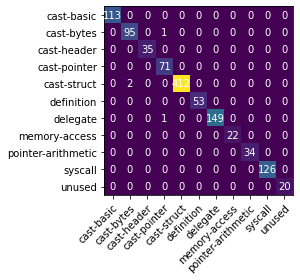

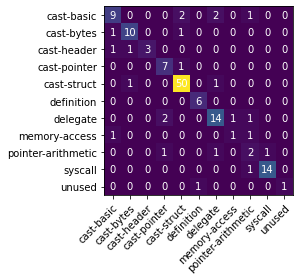

In [7]:
# Confusion matrix for label 1:
utils.draw_confusion_matrix(train_l1_conf, labels1)
utils.draw_confusion_matrix(test_l1_conf, labels1)

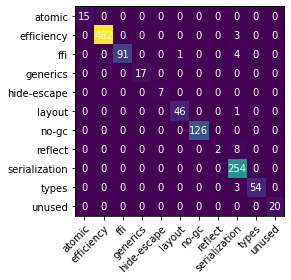

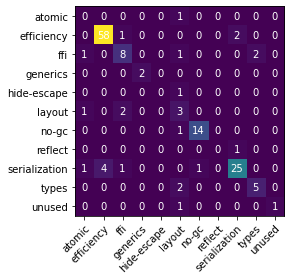

In [8]:
# Confusion matrix for label2:
utils.draw_confusion_matrix(train_l2_conf, labels2)
utils.draw_confusion_matrix(test_l2_conf, labels2)

In [9]:
# Label 1 test accuracy improvement if the cast-* labels were merged:
train_acc1 = train_results["label1_accuracy"]
test_acc1 = test_results["label1_accuracy"]
train_size = np.sum(train_l1_conf)
test_size = np.sum(test_l1_conf)
train_cast_slice = train_l1_conf[:5,:5]
test_cast_slice = test_l1_conf[:5,:5]
train_cast_size = np.sum(train_l1_conf[:5,:5])
test_cast_size = np.sum(test_l1_conf[:5,:5])

train_acc1_diff = train_cast_size - np.sum(np.diag(train_cast_slice))
test_acc1_diff = test_cast_size - np.sum(np.diag(test_cast_slice))

print(f"No. of confusions within cast labels (in train split): {train_acc1_diff}/{train_cast_size}/{train_size}")
print("Train label1 accuracy before merging:", train_acc1)
print("Train label1 accuracy after merging:", train_acc1 + train_acc1_diff / train_size)
print("---")
print(f"No. of confusions within cast labels (in test split): {test_acc1_diff}/{test_cast_size}/{test_size}")
print("Test label1 accuracy before merging:", test_acc1)
print("Test label1 accuracy after merging:", test_acc1 + test_acc1_diff / test_size)

No. of confusions within cast labels (in train split): 3/729/1134
Train label1 accuracy before merging: 0.9964726567268372
Train label1 accuracy after merging: 0.9991181593723398
---
No. of confusions within cast labels (in test split): 8/87/140
Test label1 accuracy before merging: 0.8357142806053162
Test label1 accuracy after merging: 0.8928571377481733
